# Comparing difficulty of different ascent methods
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from pprint import pprint
from scipy.stats.mstats import gmean
import datetime
%matplotlib inline

## Database stuff

In [2]:
conn   = sqlite3.connect("../database.sqlite")
cursor = conn.cursor()

## Load user data

In [3]:
dfl_user = []
df_user = pd.DataFrame()

query = "SELECT * FROM user"

for chunk in pd.read_sql(query, conn, chunksize=10000):
    dfl_user.append(chunk)
df_user = pd.concat(dfl_user, ignore_index=True)


## Load grades

In [4]:
dfl_grades = []
df_grades = pd.DataFrame()

query = "SELECT * FROM grade"
for chunk in pd.read_sql(query, conn, chunksize=10000):
    dfl_grades.append(chunk)
df_grades = pd.concat(dfl_grades, ignore_index=True)

## Load ascents

In [213]:
dfl_ascents = []
df_ascents = pd.DataFrame()

climbtype = 1

query = "SELECT * FROM ascent WHERE climb_type={0} AND total_score>0".format(climbtype) #climb_type=1 -> bouldering
for chunk in pd.read_sql(query, conn, chunksize=1000):
    dfl_ascents.append(chunk)

df_ascents = pd.concat(dfl_ascents, ignore_index=True)

## Filter out users who have 3 or less logs per method

In [179]:
tmp = df_ascents[(df_ascents["method_id"]==1) | (df_ascents["method_id"]==2) | (df_ascents["method_id"]==3) | (df_ascents["method_id"]==5)].groupby(["user_id", "method_id"]).filter(lambda x: len(x)>3)

tmp.head(10)

,id,user_id,grade_id,notes,raw_notes,method_id,climb_type,total_score,date,year,...,country,comment,rating,description,yellow_id,climb_try,repeat,exclude_from_ranking,user_recommended,chipped
0,2,1,36,,0,3,0,545,918342000,1999,...,THA,Thailand\n,0,,255,0,0,0,0,0
1,3,1,36,,0,3,0,545,925509600,1999,...,,\n,0,,0,0,0,0,0,0
2,4,1,36,,0,3,0,545,933026400,1999,...,SWE,\n,0,,255,0,0,0,0,0
3,5,1,36,,0,3,0,545,933026400,1999,...,SWE,\n,0,,255,0,0,0,0,0
4,6,1,36,,0,3,0,545,933458400,1999,...,,\n,0,,0,0,0,0,0,0
5,7,1,38,,0,3,0,595,914022000,1998,...,THA,\n,0,,255,0,0,0,0,0
6,8,1,38,,0,3,0,595,915404400,1999,...,,Indonesien\n,0,,0,0,0,0,0,0
7,9,1,38,,0,1,0,450,916268400,1999,...,THA,\n 1-3 RP,0,,255,0,0,0,0,0
8,10,1,38,,0,3,0,595,916441200,1999,...,THA,Thailand\n,0,,0,0,0,0,0,0
9,11,1,38,,0,3,0,595,917478000,1999,...,THA,\n,0,,255,0,0,0,0,0


## Get redpoints, onsights, flashes

In [180]:
## onsight = 3 or 5
## flash = 2
## redpoint = 1
redpoints = tmp[(tmp["method_id"]==1) & (tmp["grade_id"]>36)]
flashes   = tmp[(tmp["method_id"]==2) & (tmp["grade_id"]>36)]
onsights  = tmp[((tmp["method_id"]==3) | (df_ascents["method_id"]==5)) & (tmp["grade_id"]>36)]

c:\python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


## Find max grade for each user and each method

In [181]:
maxRedpoints = redpoints.groupby("user_id")["grade_id"].max()
maxFlashes   = flashes.groupby("user_id")["grade_id"].max()
maxOnsights  = onsights.groupby("user_id")["grade_id"].max()

## Create plots

In [221]:
gradeSelector = "fra_routes" if climbtype == 1 else "fra_boulders"
colors = ["#005275", "#2ca600", "#a60000"]  #"#038cfc"

grades = df_grades[["id", gradeSelector]]

[array([51, 59, 55, ..., 40, 55, 40], dtype=int64), array([62, 57, 59, ..., 49, 38, 49], dtype=int64), array([62, 62, 64, ..., 46, 49, 46], dtype=int64)]


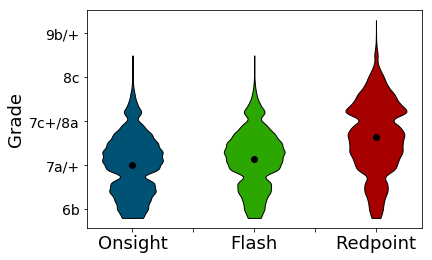

In [222]:
fig, ax = plt.subplots()
dataset = [maxOnsights.to_numpy(),
           maxFlashes.to_numpy(),
           maxRedpoints.to_numpy()
          ]
print(dataset)
violinPlot = ax.violinplot(dataset=dataset, 
              showextrema=False, 
              showmeans=False)

means = [np.mean(ds) for ds in dataset]

for i, pc in enumerate(violinPlot["bodies"]):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    ax.plot(i+1, means[i], "ok")

plt.draw()
grade_ids = [int(float(tick.get_text())) for tick in ax.get_yticklabels() if tick.get_text() != ""]
## tick labels don't necessarily match grade_id
## therefore, find the closest grade_id to a given tick label
grade_ids_processed = [min(grades["id"], key=lambda x:abs(x-grade_id)) for grade_id in grade_ids]
grade_ticks = grades[grades["id"].isin(grade_ids_processed)][gradeSelector].tolist()
grade_ticks = [""] + grade_ticks + [""]

ax.set_yticklabels(grade_ticks)

methods = ["Onsight", "Flash", "Redpoint"]
new_xticks = [methods[int(i-1)] if i%1==0 else "" for i in ax.get_xticks() ]
ax.set_xticklabels(new_xticks, fontsize=18)

ax.set_ylabel("Grade", fontsize=18)
ax.tick_params(axis="y", labelsize=14)

In [217]:
combined = pd.concat([maxFlashes.to_frame().rename(columns={"grade_id": "flash_grade"}), 
                      maxOnsights.to_frame().rename(columns={"grade_id": "onsight_grade"}),
                      maxRedpoints.to_frame().rename(columns={"grade_id": "redpoint_grade"})
                     ], 
                     axis=1)
combined = combined.dropna()
combined.head()

,flash_grade,onsight_grade,redpoint_grade
user_id,,,
4,62.0,59.0,64.0
10,57.0,55.0,64.0
15,62.0,62.0,68.0
16,51.0,53.0,64.0
18,57.0,59.0,64.0


Text(0.5,15,'Redpoint Grade')

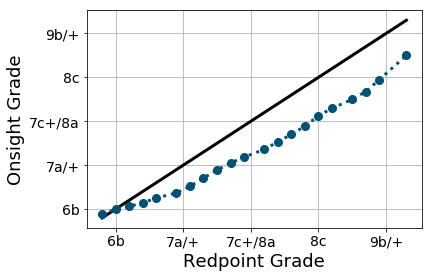

In [223]:
y1 = combined.groupby("redpoint_grade")["onsight_grade"].mean()
fig, ax = plt.subplots()
ax.plot(y1.index,y1.index, "-", color="#000000", linewidth=3)
ax.plot(y1.index, y1, ":o", color=colors[0], linewidth=3, ms=8)


plt.draw()
## tick labels don't necessarily match grade_id
## therefore, find the closest grade_id to a given tick label
grade_ids_y = [int(float(tick.get_text())) for tick in ax.get_yticklabels() if tick.get_text() != ""]
grade_ids_processed_y = [min(grades["id"], key=lambda x:abs(x-grade_id)) for grade_id in grade_ids_y]
grade_ticks_y = grades[grades["id"].isin(grade_ids_processed_y)][gradeSelector].tolist()
grade_ticks_y = [""] + grade_ticks_y + [""]

grade_ids_x = [int(float(tick.get_text())) for tick in ax.get_xticklabels() if tick.get_text() != ""]
grade_ids_processed_x = [min(grades["id"], key=lambda x:abs(x-grade_id)) for grade_id in grade_ids_x]
grade_ticks_x = grades[grades["id"].isin(grade_ids_processed_x)][gradeSelector].tolist()
grade_ticks_x = [""] + grade_ticks_x + [""]

ax.grid()
ax.set_xticklabels(grade_ticks_x, fontsize=14)
ax.set_yticklabels(grade_ticks_y, fontsize=14)
ax.set_ylabel("Onsight Grade", fontsize=18)
ax.set_xlabel("Redpoint Grade", fontsize=18)